# Predict Ship Crew Size

## Introduction

This notebook uses the `cruise_ship_info.csv` data complied by 
Benjamin Obi Tayo ([bot13956](https://github.com/bot13956) on GitHub)  to predict crew sizes for Cruise Ships. The features include `Ship_name`, `Cruise_line`, `Age`, `Tonnage`, `passengers`, `length`, `cabins` and `passenger density`. The target varable is `crew`. There are 158 records in the data set.

In [2]:
import pandas as pd

# Path to CSV file
path = "https://raw.githubusercontent.com/bot13956/ML_Model_for_Predicting_Ships_Crew_Size/master/cruise_ship_info.csv"

# Read the CSV file using pandas
df = pd.read_csv(path)

# Display the head of the DataFrame
df.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


In [3]:
df.shape

(158, 9)

## Summary Statistics

The summary statistics for the dataset show there is a large variance in the size of the features. `Age` ranges from 4 to 48, but `Tonnage` ranges from 2.32 to 220.  The XGBoost XGBRegressor model is robust to differences in variable ranges. It makes scaling or regularization unnecessary, simple regression models. The correlation matrix shows that `Tonnage`, `passengers`, `length`, and `cabins` are highly correlated with `crew`. However, we are going to run the model with all the variables and then check their feature importance to confirm the strength of the relationships.

In [4]:
df.describe()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


In [5]:
df.corr()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
Age,1.000000,-0.606646,-0.515542,-0.532286,-0.510019,-0.278830,-0.530657
Tonnage,-0.606646,1.000000,0.945061,0.922368,0.948764,-0.040846,0.927569
passengers,-0.515542,0.945061,1.000000,0.883535,0.976341,-0.294867,0.915234
length,-0.532286,0.922368,0.883535,1.000000,0.889798,-0.090488,0.895857
cabins,-0.510019,0.948764,0.976341,0.889798,1.000000,-0.253181,0.950823
passenger_density,-0.278830,-0.040846,-0.294867,-0.090488,-0.253181,1.000000,-0.155509
crew,-0.530657,0.927569,0.915234,0.895857,0.950823,-0.155509,1.000000


<AxesSubplot:>

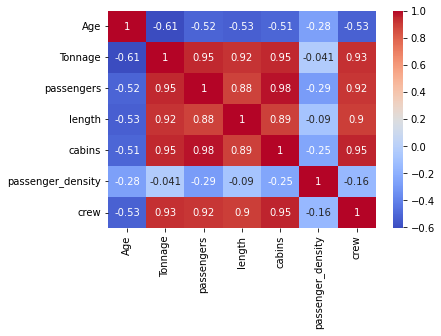

In [6]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

 There is a strong correlation between `Tonnage` and `crew`.

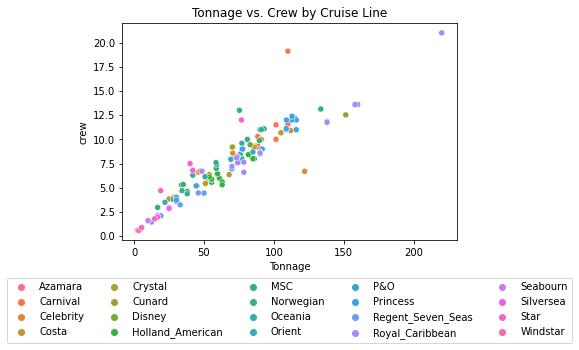

In [7]:
import matplotlib.pyplot as plt

# Create a scatter plot of age vs. tonnage, colored by cruise line
ax = sns.scatterplot(x='Tonnage', y='crew', hue='Cruise_line', data=df)
plt.title('Tonnage vs. Crew by Cruise Line')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

There is a large fluctuation in crew size between cruise lines.

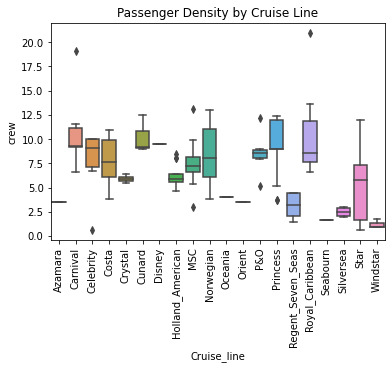

In [8]:
sns.boxplot(x='Cruise_line', y='crew', data=df)
plt.title('Passenger Density by Cruise Line')
plt.xticks(rotation=90)
plt.show()

## Model Construction and Assesment

In this section, training, validation, and test sets are built and the model is constructed. Sci-kit learn's `GridSearchCV` is used to tune hyper-parameters and the best model is tested using mean squared error. The RMSE for the best model is 3.245. The R-squared for the training set is 0.9989 the value for the test set is 0.9111. This indicates that the model is overfit. The XGBoots' feature_importance model shows that `Tonnage`, `Age`, `length`, `passenger_desity`, and `passengers` are top-5 most important features in the model.

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Convert the categorical columns to Pandas Categorical data type
df['Ship_name'] = pd.Categorical(df['Ship_name'])
df['Cruise_line'] = pd.Categorical(df['Cruise_line'])

X = df.drop('crew', axis=1)
y = df['crew']

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# One-hot encode the categorical variables
X_train_encoded = pd.get_dummies(X_train, columns=['Ship_name', 'Cruise_line'])
X_val_encoded = pd.get_dummies(X_val, columns=['Ship_name', 'Cruise_line'])
X_test_encoded = pd.get_dummies(X_test, columns=['Ship_name', 'Cruise_line'])

# Create the DMatrix objects for the training and validation data
train_dmatrix = xgb.DMatrix(X_train_encoded, label=y_train)
val_dmatrix = xgb.DMatrix(X_val_encoded, label=y_val)

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 150]
}

# Create the XGBoost regressor object
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', subsample=0.5, colsample_bytree=0.5)

# Perform a grid search over the hyperparameters using the training and validation data
grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_encoded, y_train, eval_set=[(X_val_encoded, y_val)], verbose=0)

# Print the best hyperparameters and mean squared error on the test set
print(f'Best hyperparameters: {grid_search.best_params_}')

# Make predictions on the test data using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Mean Squared Error: 2.3084


In [11]:
from scipy.stats import pearsonr

y_pred_test = best_model.predict(X_test_encoded)
y_pred_train = best_model.predict(X_train_encoded)

# Calculate the Pearson correlation coefficient for the training and testing sets
train_corr, _ = pearsonr(y_train, y_pred_train)
test_corr, _ = pearsonr(y_test, y_pred_test)

print(f'Pearson correlation coefficient (training set): {train_corr:.4f}')
print(f'Pearson correlation coefficient (testing set): {test_corr:.4f}')

Pearson correlation coefficient (training set): 0.9979
Pearson correlation coefficient (testing set): 0.9048


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

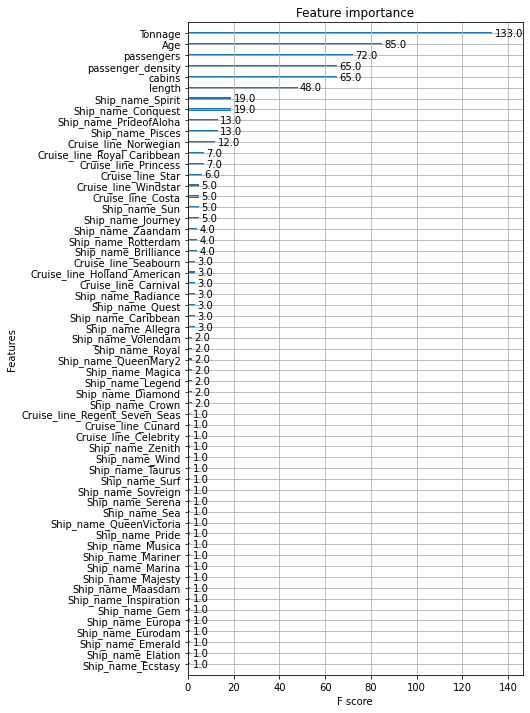

In [12]:
from xgboost import plot_importance
figsize = (6, 12)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_importance(best_model, ax=ax)

## Regularization

The XGBRegressor model has a number of regularization parameters, including `reg_alpha`, `reg_lambda`, `gamma`, and `max_depth`, which help prevent overfitting. The R-squared values for the test and training set indicate that there is a variance problem with the model since the test is overfit. However, as the chart below shows, adjusting the `reg_alpha` parameters does not significantly reduce the gap in the Pearson coefficient score between the training and test sets.

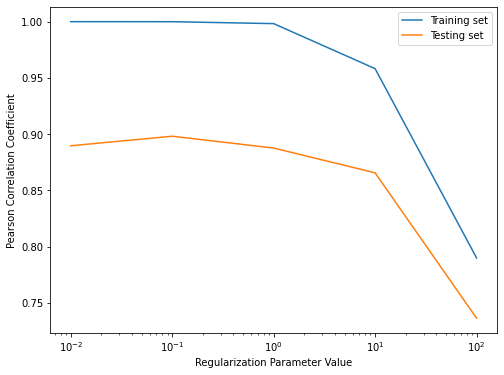

In [14]:
# Define a list of regularization parameter values to test
reg_params = [0.01, 0.1, 1, 10, 100]

# Create empty lists to store the Pearson correlation coefficients for the training and test sets
train_corr_list = []
test_corr_list = []

for reg in reg_params:
    # Create the XGBoost regressor object with the current regularization parameter value
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', subsample=0.5, colsample_bytree=0.5, reg_alpha=reg)

    # Train the model using the training data
    xgb_reg.fit(X_train_encoded, y_train)

    # Make predictions on the test data and calculate the Pearson correlation coefficient
    y_pred_test = xgb_reg.predict(X_test_encoded)
    test_corr, _ = pearsonr(y_test, y_pred_test)
    test_corr_list.append(test_corr)

    # Make predictions on the training data and calculate the Pearson correlation coefficient
    y_pred_train = xgb_reg.predict(X_train_encoded)
    train_corr, _ = pearsonr(y_train, y_pred_train)
    train_corr_list.append(train_corr)

# Create a new figure object with a larger size
fig = plt.figure(figsize=(8, 6))

# Plot the regularization parameter values vs the Pearson correlation coefficients for the training and test sets
plt.plot(reg_params, train_corr_list, label='Training set')
plt.plot(reg_params, test_corr_list, label='Testing set')
plt.xscale('log')
plt.xlabel('Regularization Parameter Value')
plt.ylabel('Pearson Correlation Coefficient')
plt.legend()
plt.show()